# Multi-class Prediction of Obesity Risk
## Kaggle Playground Series - Season 4, Episode 2
### by Diego Garrocho
---

## - Introduction
The goal of this notebook is to use various factores in order to predict obesity risk in individuals.
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Obesity or CVD risk dataset. Feature distributions are close to, but not exactly the same, as the original.

## - Data Exploration and Preparation
---


In [1]:
# Initial set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier

In [2]:
# Dataframe loading
train_df = pd.read_csv(r'C:\Users\logan\Desktop\Multi-Class Prediction of Obesity Risk\train.csv')
test_df = pd.read_csv(r'C:\Users\logan\Desktop\Multi-Class Prediction of Obesity Risk\test.csv')

In [3]:
# First looks at data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

Initial notes:
 - theres 16 features to work with after removing the target and 'id'
 - theres no missing values at all
 - there appears to be several types of data
 - Variable names are not clear to understand

In [4]:
train_df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [5]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


More notes:
 - Feature name description is really needed
 - Quantitative data will probably need to be normalized/scaled
 - Qualitative data seems to have a few binary features
 - Label encoding and One Hot encoding are needed

In [6]:
# Looking at test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

In [7]:
# Checking how many unique values there are for categorical data
for column in train_df.select_dtypes(include=['object']).columns:
    print(f"Unique values for '{column}': {train_df[column].unique()}")

Unique values for 'Gender': ['Male' 'Female']
Unique values for 'family_history_with_overweight': ['yes' 'no']
Unique values for 'FAVC': ['yes' 'no']
Unique values for 'CAEC': ['Sometimes' 'Frequently' 'no' 'Always']
Unique values for 'SMOKE': ['no' 'yes']
Unique values for 'SCC': ['no' 'yes']
Unique values for 'CALC': ['Sometimes' 'no' 'Frequently']
Unique values for 'MTRANS': ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
Unique values for 'NObeyesdad': ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


 - Most of the object features are binary values, only the target, CAEC, CALC, and MTRANS should be encoded.
 - CAEC, CALC, and NObeyesdad can use label encoder due to having hierachical nature while MTRANS doesnt.
 - MTRANS denotes transportation method and on a surface level has no effect on the target, nonetheless, an argument can be made where some methods of transportation involve more excercise and also a further correlation between transportation and social classes could be established but thats beyond the scope of this project.
 - Regarding FE, use weight with height 

In [8]:
# Transformations
# Dropping features
train_df_drop = train_df.drop(columns=['id','MTRANS'])
test_df_drop = test_df.drop(columns=['id','MTRANS'])

# Standarization for numerical features excluding age, height, weight
features_to_scale = ['FCVC','NCP','CH2O','FAF','TUE']

scaler = StandardScaler()

scale_train_df = train_df_drop.copy()
scale_test_df = test_df_drop.copy()

scale_train_df[features_to_scale] = scaler.fit_transform(scale_train_df[features_to_scale])
scale_test_df[features_to_scale] = scaler.fit_transform(scale_test_df[features_to_scale])

# Label encoding for object features
features_to_encode = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','CAEC','CALC','NObeyesdad']
features_to_encode_test = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','CAEC','CALC']

encoder = LabelEncoder()

encode_train_df = scale_train_df.copy()
encode_test_df = scale_test_df.copy()

#encode_train_df[features_to_encode] = encoder.fit_transform(encode_train_df[features_to_encode])
encode_train_df[features_to_encode] = encode_train_df[features_to_encode].apply(lambda x: encoder.fit_transform(x))

#encode_test_df[features_to_encode] = encoder.fit_transform(encode_test_df[features_to_encode])
encode_test_df[features_to_encode_test] = encode_test_df[features_to_encode_test].apply(lambda x: encoder.fit_transform(x))


In [9]:
# Feature Engineering
FE_train_df = encode_train_df
FE_test_df = encode_test_df

# BMI feature
FE_train_df['BMI'] = FE_train_df['Weight'] / (FE_train_df['Height'] / 100) ** 2
FE_test_df['BMI'] = FE_test_df['Weight'] / (FE_test_df['Height'] / 100) ** 2

# BSA by applying DuBois formula
FE_train_df['BSA'] = 0.007184 * (FE_train_df['Height'] ** 0.725) * (FE_train_df['Weight'] ** 0.425)
FE_test_df['BSA'] = 0.007184 * (FE_test_df['Height'] ** 0.725) * (FE_test_df['Weight'] ** 0.425)


In [10]:
# Weight category based on BMI like under/over/obesity

def get_weight_cat(bmi):
    if bmi < 18.5:
        return 0
    elif 18.5 <= bmi < 25:
        return 1
    elif 25 <= bmi < 30:
        return 2
    else:
        return 3

    
# Create feature in df
FE_train_df['Weight_Status'] = FE_train_df['BMI'].apply(get_weight_cat)
FE_test_df['Weight_Status'] = FE_test_df['BMI'].apply(get_weight_cat)

In [11]:
FE_train_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,BMI,BSA,Weight_Status
0,1,24.443011,1.699998,81.669950,1,1,-0.836279,0.314684,2,0,1.206594,0,-1.171141,0.597438,1,6,282595.647630,0.068560,3
1,0,18.000000,1.560000,57.000000,1,1,-0.836279,0.338364,1,0,-0.048349,0,0.021775,0.636513,2,1,234220.907298,0.055288,3
2,0,18.000000,1.711460,50.165754,1,1,-1.060332,-1.913423,2,0,-0.195644,0,-0.138022,1.755239,2,0,171267.057985,0.056005,3
3,0,20.952737,1.710730,131.274851,1,1,1.039171,0.338364,2,0,-0.584035,0,0.579896,0.271455,1,4,448557.984029,0.084266,3
4,1,31.641081,1.914186,93.798055,1,1,0.438397,-1.119801,2,0,-0.081469,0,1.176486,0.523111,1,6,255991.509829,0.079248,3


In [12]:
# Age category

def get_age_group(age):
    if age < 18:
        return 0
    elif 18 <= age < 30:
        return 1
    elif 30 <= age < 60:
        return 2
    else:
        return 3

# Create feature in df
FE_train_df['Age_Group'] = FE_train_df['Age'].apply(get_age_group)
FE_test_df['Age_Group'] = FE_test_df['Age'].apply(get_age_group)

In [13]:
# Correlation stuff

correlation_matrix = FE_train_df.corr(method='spearman')

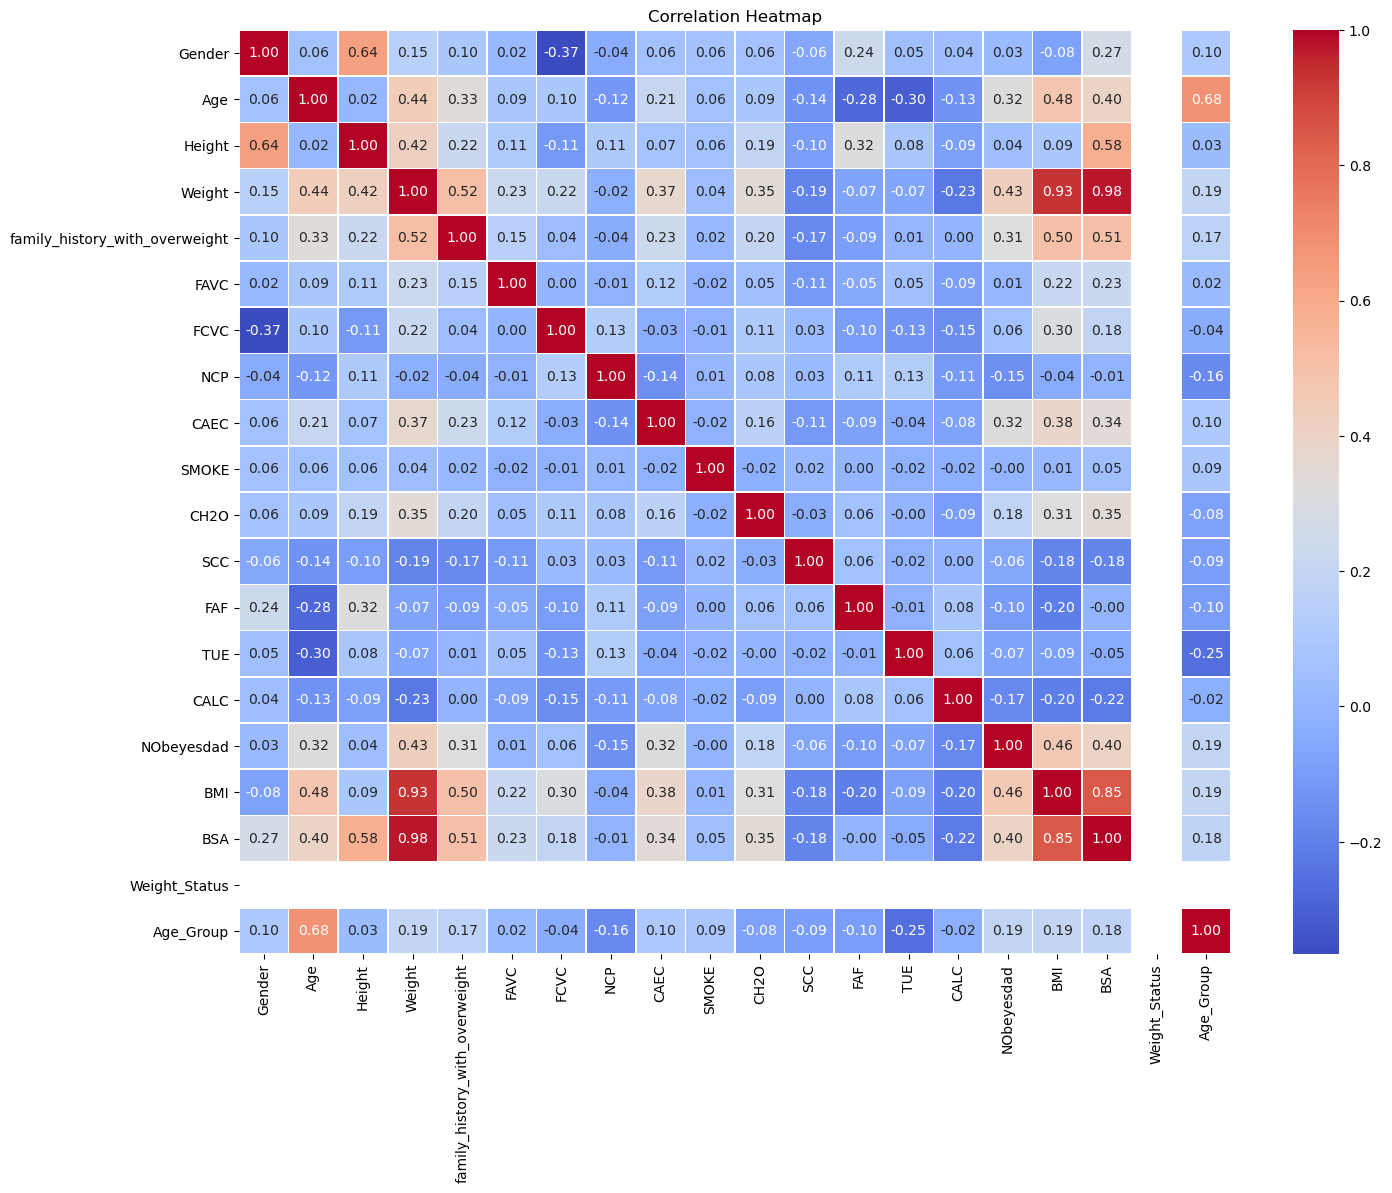

In [14]:
# Corr heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

 - A few interesting correlations found but none too strongly to the target  which was to be expected.
 - Consider removing 'Age','Weight', 'FAVC', 'FCVC', 'SMOKE', 'SCC', 'TUE'
 - Further features could be explored but without full understanding of current features no real point in it

In [15]:
# Dropping features
run_train_df = FE_train_df.drop(columns=['Age','Weight', 'FAVC', 'FCVC', 'SMOKE', 'SCC', 'TUE'])
run_test_df = FE_test_df.drop(columns=['Age','Weight', 'FAVC', 'FCVC', 'SMOKE', 'SCC', 'TUE'])



## Model training and evaluation
---
For a multiclass prediction proyect such a this, the usual suspects will probably be good enough. Gradient boosted trees are fast and efficient. For sake of speed and simplicity choosing one model would be more than enough but if theres a need for better scores running several of them in an ensamble could be explored. Optuna will be ran, unsure on the number of trails but using crossvalidation with it.

In [18]:
# Model stuff probs catboost with optuna and crossvalidation

# Splitting target
X = run_train_df.drop('NObeyesdad', axis=1)
y = run_train_df['NObeyesdad']

# Optuna params
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X, y, cv=5).mean()

In [19]:
# Running the optuna, might lower n trials to 50 if too long
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-18 00:42:18,819] A new study created in memory with name: no-name-e21d2fff-f80f-4427-8404-c1b905f5cfa7
[I 2024-03-18 00:42:31,904] Trial 0 finished with value: 0.8829369179560235 and parameters: {'iterations': 235, 'learning_rate': 0.05833898325343954, 'depth': 7, 'l2_leaf_reg': 8.346664277584283, 'border_count': 100}. Best is trial 0 with value: 0.8829369179560235.
[I 2024-03-18 00:42:45,159] Trial 1 finished with value: 0.8887658869023831 and parameters: {'iterations': 331, 'learning_rate': 0.21142118647870964, 'depth': 6, 'l2_leaf_reg': 7.240001549012623, 'border_count': 236}. Best is trial 1 with value: 0.8887658869023831.
[I 2024-03-18 00:43:23,484] Trial 2 finished with value: 0.8859236161493227 and parameters: {'iterations': 848, 'learning_rate': 0.12026490016082175, 'depth': 7, 'l2_leaf_reg': 7.769188484549473, 'border_count': 36}. Best is trial 1 with value: 0.8887658869023831.
[I 2024-03-18 00:43:40,373] Trial 3 finished with value: 0.8847190174942176 and parameter

[I 2024-03-18 00:59:37,923] Trial 29 finished with value: 0.8862127611379481 and parameters: {'iterations': 500, 'learning_rate': 0.05206970740240907, 'depth': 5, 'l2_leaf_reg': 4.772317107043764, 'border_count': 95}. Best is trial 16 with value: 0.8905001302005366.
[I 2024-03-18 01:00:48,136] Trial 30 finished with value: 0.8844301394050879 and parameters: {'iterations': 800, 'learning_rate': 0.1295778815138966, 'depth': 8, 'l2_leaf_reg': 3.770435581564114, 'border_count': 109}. Best is trial 16 with value: 0.8905001302005366.
[I 2024-03-18 01:01:06,820] Trial 31 finished with value: 0.890114808558794 and parameters: {'iterations': 915, 'learning_rate': 0.09614969587258866, 'depth': 4, 'l2_leaf_reg': 4.28327531117094, 'border_count': 70}. Best is trial 16 with value: 0.8905001302005366.
[I 2024-03-18 01:01:26,942] Trial 32 finished with value: 0.8875134900288669 and parameters: {'iterations': 936, 'learning_rate': 0.092772934954206, 'depth': 4, 'l2_leaf_reg': 4.213145050197788, 'borde

[I 2024-03-18 01:11:48,306] Trial 59 finished with value: 0.8891510460835633 and parameters: {'iterations': 931, 'learning_rate': 0.16243133062637927, 'depth': 6, 'l2_leaf_reg': 5.097801229289091, 'border_count': 162}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:12:06,547] Trial 60 finished with value: 0.8897775636392836 and parameters: {'iterations': 739, 'learning_rate': 0.18630335639613937, 'depth': 5, 'l2_leaf_reg': 4.751251987622181, 'border_count': 137}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:12:29,791] Trial 61 finished with value: 0.8902592127903809 and parameters: {'iterations': 909, 'learning_rate': 0.07878800597317992, 'depth': 5, 'l2_leaf_reg': 4.224051425219386, 'border_count': 149}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:12:53,411] Trial 62 finished with value: 0.8901627924464194 and parameters: {'iterations': 880, 'learning_rate': 0.06700179742396799, 'depth': 5, 'l2_leaf_reg': 4.426516180487556,

[I 2024-03-18 01:25:23,399] Trial 89 finished with value: 0.8907410127977148 and parameters: {'iterations': 733, 'learning_rate': 0.07239699925366838, 'depth': 6, 'l2_leaf_reg': 4.394139165630109, 'border_count': 181}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:25:46,723] Trial 90 finished with value: 0.8903074171601986 and parameters: {'iterations': 711, 'learning_rate': 0.10284831023301468, 'depth': 6, 'l2_leaf_reg': 4.377263580140068, 'border_count': 179}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:26:12,317] Trial 91 finished with value: 0.8908855330725609 and parameters: {'iterations': 784, 'learning_rate': 0.08435954558433695, 'depth': 6, 'l2_leaf_reg': 4.8518725870524975, 'border_count': 194}. Best is trial 57 with value: 0.8915598488466925.
[I 2024-03-18 01:26:36,410] Trial 92 finished with value: 0.8907410360063667 and parameters: {'iterations': 737, 'learning_rate': 0.07192833426345137, 'depth': 6, 'l2_leaf_reg': 3.416033990241798

In [20]:
# Fitting model and hyperparams
best_params = study.best_params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X, y)

print(best_params)

0:	learn: 1.5071196	total: 5.69ms	remaining: 4.72s
1:	learn: 1.2557353	total: 10.5ms	remaining: 4.34s
2:	learn: 1.0972364	total: 15.5ms	remaining: 4.27s
3:	learn: 0.9719600	total: 20.9ms	remaining: 4.33s
4:	learn: 0.8830283	total: 27.2ms	remaining: 4.49s
5:	learn: 0.8089476	total: 32.6ms	remaining: 4.49s
6:	learn: 0.7458112	total: 37.6ms	remaining: 4.43s
7:	learn: 0.6967822	total: 42.8ms	remaining: 4.4s
8:	learn: 0.6595033	total: 47.6ms	remaining: 4.35s
9:	learn: 0.6260417	total: 53.1ms	remaining: 4.36s
10:	learn: 0.5971364	total: 60.5ms	remaining: 4.51s
11:	learn: 0.5752085	total: 65.6ms	remaining: 4.48s
12:	learn: 0.5547708	total: 70.7ms	remaining: 4.45s
13:	learn: 0.5378296	total: 75.5ms	remaining: 4.41s
14:	learn: 0.5211911	total: 80.4ms	remaining: 4.37s
15:	learn: 0.5062591	total: 85.4ms	remaining: 4.35s
16:	learn: 0.4925067	total: 93.2ms	remaining: 4.46s
17:	learn: 0.4843648	total: 98.3ms	remaining: 4.44s
18:	learn: 0.4741032	total: 103ms	remaining: 4.42s
19:	learn: 0.4659146	tot

169:	learn: 0.2940574	total: 848ms	remaining: 3.3s
170:	learn: 0.2937773	total: 854ms	remaining: 3.29s
171:	learn: 0.2934306	total: 859ms	remaining: 3.29s
172:	learn: 0.2931342	total: 863ms	remaining: 3.28s
173:	learn: 0.2928680	total: 868ms	remaining: 3.28s
174:	learn: 0.2926331	total: 873ms	remaining: 3.27s
175:	learn: 0.2923263	total: 878ms	remaining: 3.27s
176:	learn: 0.2921039	total: 883ms	remaining: 3.26s
177:	learn: 0.2919079	total: 888ms	remaining: 3.26s
178:	learn: 0.2917722	total: 892ms	remaining: 3.25s
179:	learn: 0.2915788	total: 897ms	remaining: 3.24s
180:	learn: 0.2913787	total: 901ms	remaining: 3.24s
181:	learn: 0.2911642	total: 907ms	remaining: 3.23s
182:	learn: 0.2909886	total: 913ms	remaining: 3.23s
183:	learn: 0.2908330	total: 918ms	remaining: 3.23s
184:	learn: 0.2905756	total: 924ms	remaining: 3.22s
185:	learn: 0.2903339	total: 928ms	remaining: 3.22s
186:	learn: 0.2901475	total: 933ms	remaining: 3.21s
187:	learn: 0.2899968	total: 938ms	remaining: 3.21s
188:	learn: 0

341:	learn: 0.2617983	total: 1.7s	remaining: 2.43s
342:	learn: 0.2617193	total: 1.71s	remaining: 2.43s
343:	learn: 0.2616448	total: 1.71s	remaining: 2.42s
344:	learn: 0.2615373	total: 1.71s	remaining: 2.42s
345:	learn: 0.2614675	total: 1.72s	remaining: 2.41s
346:	learn: 0.2612949	total: 1.72s	remaining: 2.4s
347:	learn: 0.2611425	total: 1.73s	remaining: 2.4s
348:	learn: 0.2609160	total: 1.73s	remaining: 2.4s
349:	learn: 0.2606518	total: 1.74s	remaining: 2.39s
350:	learn: 0.2604634	total: 1.74s	remaining: 2.38s
351:	learn: 0.2603485	total: 1.75s	remaining: 2.38s
352:	learn: 0.2602002	total: 1.75s	remaining: 2.37s
353:	learn: 0.2600848	total: 1.76s	remaining: 2.37s
354:	learn: 0.2599621	total: 1.76s	remaining: 2.36s
355:	learn: 0.2598905	total: 1.77s	remaining: 2.36s
356:	learn: 0.2597065	total: 1.77s	remaining: 2.35s
357:	learn: 0.2596618	total: 1.78s	remaining: 2.35s
358:	learn: 0.2594292	total: 1.78s	remaining: 2.34s
359:	learn: 0.2593097	total: 1.78s	remaining: 2.34s
360:	learn: 0.25

513:	learn: 0.2415709	total: 2.54s	remaining: 1.56s
514:	learn: 0.2415055	total: 2.54s	remaining: 1.56s
515:	learn: 0.2414505	total: 2.54s	remaining: 1.55s
516:	learn: 0.2413716	total: 2.55s	remaining: 1.55s
517:	learn: 0.2413278	total: 2.56s	remaining: 1.54s
518:	learn: 0.2412093	total: 2.56s	remaining: 1.54s
519:	learn: 0.2411001	total: 2.56s	remaining: 1.53s
520:	learn: 0.2409686	total: 2.57s	remaining: 1.53s
521:	learn: 0.2408567	total: 2.58s	remaining: 1.52s
522:	learn: 0.2408080	total: 2.58s	remaining: 1.52s
523:	learn: 0.2406867	total: 2.58s	remaining: 1.51s
524:	learn: 0.2405841	total: 2.59s	remaining: 1.51s
525:	learn: 0.2404737	total: 2.59s	remaining: 1.5s
526:	learn: 0.2403062	total: 2.6s	remaining: 1.5s
527:	learn: 0.2402609	total: 2.6s	remaining: 1.49s
528:	learn: 0.2401117	total: 2.61s	remaining: 1.49s
529:	learn: 0.2399701	total: 2.62s	remaining: 1.49s
530:	learn: 0.2399076	total: 2.62s	remaining: 1.48s
531:	learn: 0.2397813	total: 2.62s	remaining: 1.48s
532:	learn: 0.23

688:	learn: 0.2258667	total: 3.39s	remaining: 699ms
689:	learn: 0.2258307	total: 3.4s	remaining: 694ms
690:	learn: 0.2257598	total: 3.4s	remaining: 689ms
691:	learn: 0.2256407	total: 3.41s	remaining: 684ms
692:	learn: 0.2253771	total: 3.41s	remaining: 679ms
693:	learn: 0.2253346	total: 3.42s	remaining: 674ms
694:	learn: 0.2252829	total: 3.42s	remaining: 669ms
695:	learn: 0.2252699	total: 3.42s	remaining: 664ms
696:	learn: 0.2251975	total: 3.43s	remaining: 659ms
697:	learn: 0.2250730	total: 3.44s	remaining: 655ms
698:	learn: 0.2250086	total: 3.44s	remaining: 650ms
699:	learn: 0.2248610	total: 3.44s	remaining: 645ms
700:	learn: 0.2248350	total: 3.45s	remaining: 640ms
701:	learn: 0.2247717	total: 3.45s	remaining: 635ms
702:	learn: 0.2247154	total: 3.46s	remaining: 630ms
703:	learn: 0.2246178	total: 3.46s	remaining: 625ms
704:	learn: 0.2245467	total: 3.47s	remaining: 620ms
705:	learn: 0.2244330	total: 3.47s	remaining: 615ms
706:	learn: 0.2243636	total: 3.48s	remaining: 610ms
707:	learn: 0.

In [28]:
# Running the model, reversing encoding and creating submission file
predictions_encoded = best_model.predict(run_test_df)
predictions_encoded_s = np.squeeze(predictions_encoded)
#predictions = encoder.inverse_transform(predictions_encoded)
pred_df = pd.DataFrame({'NObeyesdad_enc': predictions_encoded_s})
almost_df = pd.DataFrame({'id': test_df['id'], 'NObeyesdad_enc': pred_df['NObeyesdad_enc']})
#almost_df.to_csv('submission.csv', index=False)

In [34]:
# Having to manually reverse encoding
def map_weight_status(NObeyesdad_enc):
    if NObeyesdad_enc == 0:
        return 'Insufficient_Weight'
    elif NObeyesdad_enc == 1:
        return 'Normal_Weight'
    elif NObeyesdad_enc == 2:
        return 'Obesity_Type_I'
    elif NObeyesdad_enc == 3:
        return 'Obesity_Type_II'
    elif NObeyesdad_enc == 4:
        return 'Obesity_Type_III'
    elif NObeyesdad_enc == 5:
        return 'Overweight_Level_I'
    elif NObeyesdad_enc == 6:
        return 'Overweight_Level_II'
    else:
        return 'Unknown'  

almost_df['NObeyesdad'] = almost_df['NObeyesdad_enc'].apply(map_weight_status)

In [41]:
# Dropping encoded feature
#almost_df.drop('NObeyesdad_enc', axis=1, inplace=True)
submission_df = almost_df.copy()
submission_df.to_csv('submission.csv', index=False)

In [42]:
submission_df.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_I


# Results
---
After submitting the predictions from this model, the score given to the prediction by kaggle was 0.81177 as a Public Score which lands it in the lower positions on the leaderboards but still a reasobale score.